In [566]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

%matplotlib inline

In [567]:
df = pd.read_csv("data/processed/final.csv")
df.head()
df.columns

Index(['cid', 'action', 'smiles'], dtype='object')

In [568]:
df['action'].value_counts()

PARTIAL AGONIST    127
AGONIST             94
ANTAGONIST          45
FULL AGONIST        19
BINDER               2
POSITIVE             2
NEUTRAL              2
OTHER/UNKNOWN        1
LIGAND               1
BIASED AGONIST       1
Name: action, dtype: int64

In [569]:
def parse(x):
    x = str(x)
    if x.startswith("FULL "):
        return "AGONIST"
    else:
        return x
        
df["action_gen"] = df["action"].apply(parse)
df["action_gen"].value_counts()

PARTIAL AGONIST    127
AGONIST            113
ANTAGONIST          45
BINDER               2
nan                  2
POSITIVE             2
NEUTRAL              2
OTHER/UNKNOWN        1
LIGAND               1
BIASED AGONIST       1
Name: action_gen, dtype: int64

In [570]:
condition = (df.action_gen != "AGONIST") & (df.action_gen != "ANTAGONIST") & (df.action_gen != "PARTIAL AGONIST")
df["action_gen"] = np.where(condition, "OTHER", df.action_gen)
df["action_gen"].value_counts()

PARTIAL AGONIST    127
AGONIST            113
ANTAGONIST          45
OTHER               11
Name: action_gen, dtype: int64

In [571]:
df = df.drop_duplicates(subset=['cid'])
df = df[['cid', 'smiles', 'action', 'action_gen']]
df.set_index('cid', inplace=True)
df.to_csv('data/processed/final_4_category.csv')

In [572]:
df_parse = df[df["action_gen"] != "OTHER"]
df_parse.reset_index(inplace=True)

In [573]:
X = df_parse[["cid", "smiles"]]
y = df_parse[["action_gen"]]

## Undersampling & Oversampling

In [574]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [575]:
SIZE = 60
over = RandomOverSampler(sampling_strategy={'ANTAGONIST': SIZE})
# fit and apply the transform
X, y = over.fit_resample(X, y)
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy={'PARTIAL AGONIST': SIZE + 20, 'AGONIST': SIZE + 10})
# fit and apply the transform
X, y = under.fit_resample(X, y)

In [576]:
df = pd.concat([X, y], axis=1)

In [577]:
print(">>> create mol from smiles ... ")
df['mol'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

print(">>> create sentence from mol ... ")
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], radius=1)), axis=1)

print(">>> load the word2vec model ... ")
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec.load('model\\model_300dim.pkl')
# w2v_model = word2vec.Word2Vec.load('model_300dim.pkl')

print(">>> create embedding from sentence ... ")
df['embedding'] = [DfVec(x) for x in sentences2vec(df['sentence'], w2v_model)]

print(">>> data columns = ", df.columns, "\n")

df_mol2vec = np.array([x.vec for x in df['embedding']])
df_mol2vec = pd.DataFrame(df_mol2vec)
df_mol2vec

>>> create mol from smiles ... 
>>> create sentence from mol ... 
>>> load the word2vec model ... 
>>> create embedding from sentence ... 
>>> data columns =  Index(['cid', 'smiles', 'action_gen', 'mol', 'sentence', 'embedding'], dtype='object') 



,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.808758,-3.756391,-1.144994,5.116853,1.805863,-1.599156,-11.152855,0.409651,6.866855,-0.748342,...,-1.958525,12.554415,10.737741,-0.083683,-9.564690,-2.951824,-3.560027,-6.441918,-11.949931,-3.966004
1,0.619165,-3.699804,-3.688030,1.413995,1.368354,-6.651547,-13.590994,2.757429,3.370274,2.640249,...,-2.574120,15.301981,6.480038,1.606085,-12.458905,-10.682524,-8.736527,-5.380240,-16.338335,1.824793
2,1.310050,0.504837,-3.955574,3.383390,0.083023,-2.071843,-12.156094,1.097509,7.664642,2.045137,...,-2.611433,11.828957,9.120181,-0.114614,-11.011421,-6.701509,-7.150333,-5.664007,-10.578299,-1.443004
3,2.616493,-1.805237,-1.552049,4.284655,-1.366528,-3.916826,-8.756064,4.684719,-1.132669,2.197711,...,-1.492761,13.124360,3.519817,-0.463862,-11.457003,-7.321039,-9.967497,0.218193,-7.686374,1.708560
4,0.470723,-2.132651,-1.004214,3.989480,-0.290720,-7.012212,-14.124387,4.198347,1.262004,0.614888,...,-4.208807,15.056268,6.524079,-2.986403,-15.526501,-12.189074,-9.324614,-3.716681,-9.397925,1.024810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,-10.463787,-10.161967,-1.861415,-2.378057,20.675098,-10.116720,-50.522667,-11.981977,49.108356,0.378932,...,6.146253,37.547058,45.017548,25.573624,-34.595623,-5.993409,-4.127573,-41.574436,-50.190807,-8.451612
206,1.238312,-5.304539,-2.136388,7.568429,-2.111284,-2.232839,-17.637012,0.490300,7.695356,2.943468,...,-1.198793,20.002918,11.489108,0.695822,-13.073326,-7.375031,-10.396597,-4.624929,-16.982567,0.950502
207,-0.087833,-5.175261,-0.872487,6.155688,-2.814585,-1.842228,-13.217561,0.979104,9.047121,1.131404,...,-1.869926,14.941614,9.852917,1.051333,-10.357376,-3.547397,-8.912207,-3.753923,-11.112837,-0.850803
208,5.997138,-6.954918,-0.887076,5.344829,-2.958733,-3.815748,-13.253129,5.932392,-1.211188,4.391876,...,-0.462063,20.250456,3.825267,-3.874045,-16.655293,-9.944824,-15.146537,-3.631362,-12.900338,0.722468


### PCA then TSNE

In [578]:
np.random.seed(42)

In [579]:
X_raw = df_mol2vec

In [580]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sc = StandardScaler()
pca = PCA(random_state=42)
tsne = TSNE(random_state=42)

tsne_after_pca = Pipeline([
    ('std_scaler', sc),
    ('pca', pca),
    ('tsne', tsne)
])

X_tsne_pca = tsne_after_pca.fit_transform(df_mol2vec)
X_tsne_pca.shape

c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(210, 2)

### Kernel PCA then TSNE

In [581]:
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap


sc = StandardScaler()
kpca = KernelPCA(n_components=10, kernel='rbf', 
                 gamma=0.01, random_state=42)
# kpca = KernelPCA(kernel='rbf', random_state=42)
tsne = TSNE(n_components=2)
mds = MDS(n_components=2, metric=True, random_state=42)
isomap = Isomap(n_neighbors=5, n_components=42, 
                eigen_solver='auto')


scaled_kpca = Pipeline([
    ('std_scaler', sc),
    ('pca', kpca),
    ('tsne', tsne),
    # ('mds', mds),
    # ('isomap', isomap),
])

X_tsne_kernel_pca = scaled_kpca.fit_transform(df_mol2vec)
X_tsne_kernel_pca.shape

c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(210, 2)

In [582]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline

# clf = Pipeline([
#     ("kpca", KernelPCA(gamma=0.01, random_state=42)),
#     ("log_reg", RandomForestClassifier())
#  ])
# param_grid = [{
#  "kpca__n_components": [None] + [i for i in range(10)],
#  "kpca__gamma": np.arange(0.01, 10, 0.01),
#  "kpca__kernel": ["rbf", "sigmoid"]
#  }]
# grid_search = GridSearchCV(clf, param_grid, cv=3)
# grid_search.fit(df_mol2vec, y["action_gen"].to_list())

In [583]:
# print(grid_search.best_params_)

### LDA

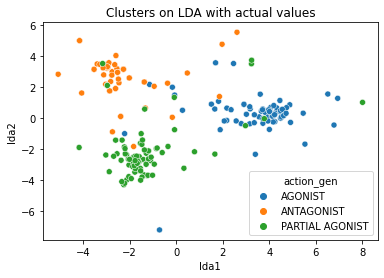

In [594]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

np.random.seed(42)
df_mol2vec_scaled = df_mol2vec
scaler = StandardScaler()
df_mol2vec_scaled = pd.DataFrame(scaler.fit_transform(df_mol2vec))
df_mol2vec_scaled['action_gen'] = df['action_gen']


# normal LDA 
n_comp = 2
# lda = LDA(n_components=n_comp).fit(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1])

# normal LDA with partial training set to prevent overfitting
# df_sample = df_mol2vec_scaled.sample(n=130)
# lda = LDA(n_components=n_comp).fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
# X_train, X_test, y_train, y_test = train_test_split(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1], 
#                                                 train_size=0.70, random_state=42)
# lda = LDA(n_components=n_comp).fit(X_train, y_train)

# solve generalized eigenvalue problem
X_train, X_test, y_train, y_test = train_test_split(df_mol2vec_scaled.iloc[:, :-1], df_mol2vec_scaled.iloc[:, -1], 
                                                train_size=0.6, random_state=42)
lda = LDA(n_components=n_comp, solver='eigen', shrinkage=0.025).fit(X_train, y_train)

df_mol2vec_scaled.drop("action_gen", axis=1, inplace=True)
lda_results = lda.transform(df_mol2vec_scaled)
# lda_results = lda.transform(X_test)

lda_results = pd.DataFrame(lda_results, columns=['lda' + str(i) for i in range(1, n_comp+1)])
# sns.scatterplot(x='lda1', y="lda2", hue=y_test, data=lda_results)
sns.scatterplot(x='lda1', y="lda2", hue=df['action_gen'], data=lda_results)
plt.title('Clusters on LDA with actual values')
plt.show()

In [584]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("lda", LDA(n_components=2))
 ])
param_grid = [{
 "lda__shrinkage": np.arange(0.001, 0.5, 0.001),
 "lda__solver": ["eigen"]
 }]
grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(df_mol2vec, y["action_gen"].to_list())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('lda',
                                        LinearDiscriminantAnalysis(n_components=2))]),
             param_grid=[{'lda__shrinkage': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0....
       0.442, 0.443, 0.444, 0.445, 0.446, 0.447, 0.448, 0.449, 0.45 ,
       0.451, 0.452, 0.453, 0.454, 0.455, 0.456, 0.457, 0.458, 0.459,
       0.46 , 0.461, 0.462, 0.463, 0.464, 0.465, 0.466, 0.467, 0.468,
       0.469, 0.47 , 0.471, 0.472, 0.473, 0.474, 0.475, 0.476, 0.477,
       0.478, 0.479, 0.48 , 0.481, 0.482, 0.483, 0.484, 0.485, 0.486,
       0.487, 0.488, 0.489, 0.49 , 0.491, 0.492, 0.493, 0.494, 0.495,
       0.496, 0.497, 0.498, 0.499]),
                          'lda__solver': ['eigen']}]

In [585]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'lda__shrinkage': 0.004, 'lda__solver': 'eigen'}
0.8428571428571429


### SVD then TSNE


In [ ]:
from sklearn.decomposition import TruncatedSVD

sc = StandardScaler()
svd = TruncatedSVD(random_state=42)
tsne = TSNE(random_state=42)

tsne_after_svd = Pipeline([
    ('std_scaler', sc),
    ('svd', svd),
    ('tsne', tsne)
])

X_tsne_svd = tsne_after_svd.fit_transform(df_mol2vec)
X_tsne_svd.shape

c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Public\anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(210, 2)

In [ ]:
# X = X_tsne_pca
# X = X_tsne_svd
# X = X_tsne_kernel_pca
X = lda_results.values
# X = X_raw

<AxesSubplot:>

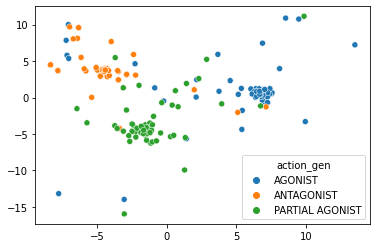

In [ ]:
X_plot = X
# if X.shape[1] > 2:
#     tsne = TSNE(n_components=2, random_state=42)
#     X_plot = tsne.fit_transform(X)
sns.scatterplot(x=X_plot[:, 0], y=X_plot[:, 1], hue=df["action_gen"])

## K-means

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import rand_score

In [ ]:
from sklearn.cluster import KMeans # lowest is optimal
clusterer = KMeans(n_clusters=3, random_state=42)
kmeans_result = clusterer.fit_predict(X)
result = pd.DataFrame(kmeans_result, columns=["clusters"])

In [ ]:
print(result['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(result['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1])).keys()
cluster_dict = list(cluster_dict)

result['action_gen'] = df['action_gen']
result['action_gen_cluster'] = result['clusters'].map({cluster_dict[1]: 'AGONIST', cluster_dict[0]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST'})

print('pairing_score: ', rand_score(result.action_gen, result.action_gen_cluster))
result[result.action_gen == result.action_gen_cluster].shape[0] / result.shape[0]
# print('Accuracy', accuracy_score(result.action_gen, result.action_gen_cluster))
print(classification_report(result.action_gen, result.action_gen_cluster))


1    75
2    70
0    65
Name: clusters, dtype: int64
pairing_score:  0.8601503759398497
                 precision    recall  f1-score   support

        AGONIST       0.86      0.86      0.86        70
     ANTAGONIST       0.86      0.93      0.90        60
PARTIAL AGONIST       0.93      0.88      0.90        80

       accuracy                           0.89       210
      macro avg       0.88      0.89      0.89       210
   weighted avg       0.89      0.89      0.89       210



## Hierarchical Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

hier_thresh = AgglomerativeClustering(n_clusters=3, linkage='complete')
agglomerative_result = hier_thresh.fit_predict(X)
result = pd.DataFrame(agglomerative_result, columns=["clusters"])

In [ ]:
print(result['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(result['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1])).keys()
cluster_dict = list(cluster_dict)

result['action_gen'] = df['action_gen']
result['action_gen_cluster'] = result['clusters'].map({cluster_dict[1]: 'AGONIST', cluster_dict[0]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST'})

print('pairing_score: ', rand_score(result.action_gen, result.action_gen_cluster))
result[result.action_gen == result.action_gen_cluster].shape[0] / result.shape[0]
# print('Accuracy', accuracy_score(result.action_gen, result.action_gen_cluster))
print(classification_report(result.action_gen, result.action_gen_cluster))


0    137
2     64
1      9
Name: clusters, dtype: int64
pairing_score:  0.674231032125769
                 precision    recall  f1-score   support

        AGONIST       0.91      0.83      0.87        70
     ANTAGONIST       0.00      0.00      0.00        60
PARTIAL AGONIST       0.51      0.88      0.65        80

       accuracy                           0.61       210
      macro avg       0.47      0.57      0.50       210
   weighted avg       0.50      0.61      0.53       210



## Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

spectral_cluster = SpectralClustering(n_clusters=3)
spectral_result = spectral_cluster.fit_predict(X)
result = pd.DataFrame(spectral_result, columns=["clusters"])

In [ ]:
print(result['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(result['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1])).keys()
cluster_dict = list(cluster_dict)

result['action_gen'] = df['action_gen']
result['action_gen_cluster'] = result['clusters'].map({cluster_dict[1]: 'AGONIST', cluster_dict[0]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST'})

print('pairing_score: ', rand_score(result.action_gen, result.action_gen_cluster))
result[result.action_gen == result.action_gen_cluster].shape[0] / result.shape[0]
# print('Accuracy', accuracy_score(result.action_gen, result.action_gen_cluster))
print(classification_report(result.action_gen, result.action_gen_cluster))


0    203
2      4
1      3
Name: clusters, dtype: int64
pairing_score:  0.35552517657780813
                 precision    recall  f1-score   support

        AGONIST       0.75      0.04      0.08        70
     ANTAGONIST       0.00      0.00      0.00        60
PARTIAL AGONIST       0.38      0.97      0.55        80

       accuracy                           0.39       210
      macro avg       0.38      0.34      0.21       210
   weighted avg       0.40      0.39      0.24       210



## Birch Algorithm

In [ ]:
from sklearn.cluster import Birch

birch = Birch(n_clusters = 3)
birch_result = birch.fit_predict(X)
result = pd.DataFrame(birch_result, columns=["clusters"])

In [ ]:
print(result['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(result['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1])).keys()
cluster_dict = list(cluster_dict)

result['action_gen'] = df['action_gen']
result['action_gen_cluster'] = result['clusters'].map({cluster_dict[1]: 'AGONIST', cluster_dict[0]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST'})

print('pairing_score: ', rand_score(result.action_gen, result.action_gen_cluster))
result[result.action_gen == result.action_gen_cluster].shape[0] / result.shape[0]
# print('Accuracy', accuracy_score(result.action_gen, result.action_gen_cluster))
print(classification_report(result.action_gen, result.action_gen_cluster))


0    92
1    64
2    54
Name: clusters, dtype: int64
pairing_score:  0.8313966735019367
                 precision    recall  f1-score   support

        AGONIST       0.91      0.83      0.87        70
     ANTAGONIST       0.89      0.80      0.84        60
PARTIAL AGONIST       0.82      0.94      0.87        80

       accuracy                           0.86       210
      macro avg       0.87      0.86      0.86       210
   weighted avg       0.87      0.86      0.86       210



## Gaussian Mixture

In [ ]:
from sklearn.mixture import GaussianMixture

gauss = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gauss_result = gauss.fit_predict(X)
result = pd.DataFrame(gauss_result, columns=["clusters"])

In [ ]:
print(result['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(result['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1])).keys()
cluster_dict = list(cluster_dict)

result['action_gen'] = df['action_gen']
result['action_gen_cluster'] = result['clusters'].map({cluster_dict[1]: 'AGONIST', cluster_dict[0]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST'})

print('pairing_score: ', rand_score(result.action_gen, result.action_gen_cluster))
result[result.action_gen == result.action_gen_cluster].shape[0] / result.shape[0]
# print('Accuracy', accuracy_score(result.action_gen, result.action_gen_cluster))
print(classification_report(result.action_gen, result.action_gen_cluster))


0    83
1    65
2    62
Name: clusters, dtype: int64
pairing_score:  0.8590567327409433
                 precision    recall  f1-score   support

        AGONIST       0.08      0.07      0.07        70
     ANTAGONIST       0.03      0.03      0.03        60
PARTIAL AGONIST       0.88      0.91      0.90        80

       accuracy                           0.38       210
      macro avg       0.33      0.34      0.33       210
   weighted avg       0.37      0.38      0.38       210



# Supervised + Grid_Search

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split


clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf4 = DecisionTreeClassifier(random_state=42)
clf5 = KNeighborsClassifier()
clf6 = MultinomialNB()
clf7 = GradientBoostingClassifier(random_state=42)
clf8 = LDA(n_components=2)

In [ ]:
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['classifier'] = [clf6]

param7 = {}
param7['classifier__n_estimators'] = [10, 50, 100, 250]
param7['classifier__max_depth'] = [5, 10, 20]
param7['classifier'] = [clf7]

param8 = {}
param8["classifier__shrinkage"] = np.arange(0.001, 0.5, 0.001)
param8["classifier__solver"] = ["eigen"]
param8['classifier'] = [clf8]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_mol2vec, y.values.ravel(), test_size=0.2, random_state=42, stratify=y)
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param4, param5, param6, param7, param8]
gs = GridSearchCV(pipeline, params, cv=10, scoring='accuracy').fit(X_train, y_train)

In [ ]:
print(gs.best_params_)
print(gs.best_score_)
